In [ ]:
# Metadata:
metadata = {
    "law_name": "Bộ luật Lao động 2019",
    "chapter": "Chương II. Hợp đồng lao động",
    "article": "Điều 13. Hợp đồng lao động",
    "clause": "Khoản 1"
}

# Nội dung gốc:
page_content = "Hợp đồng lao động là sự thoả thuận giữa người lao động và người sử dụng lao động về..."

# Ghép lại trước khi đưa vào prompt:
final_input = f"""{metadata['law_name']}
{metadata['chapter']}
{metadata['article']}
{metadata['clause']}

{page_content}
"""

In [32]:
print(final_input)

Bộ luật Lao động 2019
Chương II. Hợp đồng lao động
Điều 13. Hợp đồng lao động
Khoản 1

Hợp đồng lao động là sự thoả thuận giữa người lao động và người sử dụng lao động về...



# Chunking với MarkdownHeaderTextSplitter

In [33]:
from langchain.text_splitter import MarkdownHeaderTextSplitter, RecursiveCharacterTextSplitter

In [34]:
markdown_path = "/content/L_64_2025_QH15.txt"

with open(markdown_path, 'r', encoding='utf-8') as f:
    markdown_text = f.read()

In [35]:
headers_to_split_on = [
    ("#", "chu_de"),
    ("##", "chuong"),
    ("###", "dieu"),
]

In [36]:
splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on,
    strip_headers=True
)

docs = splitter.split_text(markdown_text)

In [37]:
print(len(docs))

80


In [38]:
print(docs[4])

page_content='Trong Luật này, các từ ngữ dưới đây được hiểu như sau:
1. Quy phạm pháp luật là quy tắc xử sự chung, có hiệu lực bắt buộc chung, được áp dụng đối với cơ quan,
tổ chức, cá nhân, trong phạm vi cả nước hoặc trong đơn vị hành chính nhất định, do cơ quan nhà nước,
người có thẩm quyền quy định tại Luật này ban hành và được Nhà nước bảo đảm thực hiện.
2. Chính sách là tập hợp các giải pháp cụ thể của Nhà nước để giải quyết một hoặc một số vấn đề của thực
tiễn nhằm đạt được mục tiêu nhất định, phù hợp với chủ trương, đường lối của Đảng.
3. Tham vấn chính sách là việc trao đổi trực tiếp giữa cơ quan lập đề xuất chính sách với cơ quan, tổ chức,
cá nhân được tham vấn theo quy định của Luật này nhằm lựa chọn giải pháp, hoàn thiện chính sách của dự
án luật, nghị quyết của Quốc hội, pháp lệnh của Ủy ban Thường vụ Quốc hội.
4. Đánh giá tác động của chính sách là việc phân tích, dự báo khả năng ảnh hưởng của từng giải pháp nhằm
lựa chọn phương án tối ưu, phù hợp với mục tiêu của chính sá

In [39]:
print(docs[4].metadata)

{'chu_de': 'LUẬT: BAN HÀNH VĂN BẢN QUY PHẠM PHÁP LUẬT', 'chuong': 'Chương I - NHỮNG QUY ĐỊNH CHUNG', 'dieu': 'Điều 3. Giải thích từ ngữ'}


In [40]:
print(len(docs[1].page_content))

117


In [41]:
from statistics import mean, median

def analyze_doc_lengths(docs):
    lengths = [len(doc.page_content) for doc in docs]

    print(f" Tổng số chunk: {len(lengths)}")
    print(f" Độ dài nhỏ nhất: {min(lengths)} ký tự")
    print(f" Độ dài lớn nhất: {max(lengths)} ký tự")
    print(f" Độ dài trung bình: {mean(lengths):.2f} ký tự")
    print(f" Độ dài trung vị  : {median(lengths)} ký tự")

    import matplotlib.pyplot as plt
    import numpy as np

    plt.hist(lengths, bins=np.arange(0, max(lengths) + 200, 200), edgecolor='black')
    plt.title("Phân bố độ dài các chunk")
    plt.xlabel("Độ dài (số ký tự)")
    plt.ylabel("Số chunk")
    plt.grid(True)
    plt.show()

 Tổng số chunk: 80
 Độ dài nhỏ nhất: 26 ký tự
 Độ dài lớn nhất: 4907 ký tự
 Độ dài trung bình: 1227.91 ký tự
 Độ dài trung vị  : 923.5 ký tự


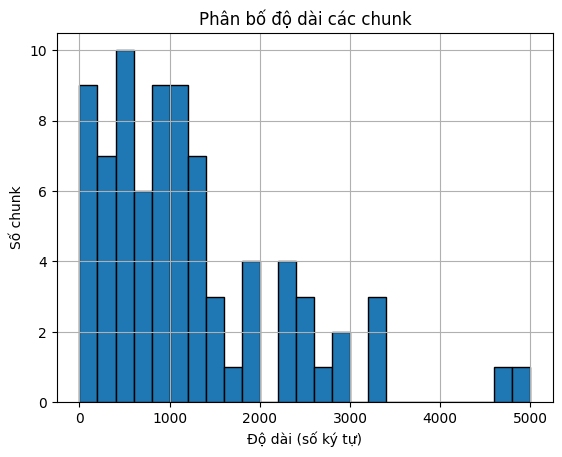

In [42]:
analyze_doc_lengths(docs)

# Metadata enrichment

In [43]:
import re
from datetime import datetime

def extract_legal_metadata(markdown_text):
    lines = markdown_text.strip().splitlines()
    lines = [line.strip() for line in lines if line.strip() != ""]

    metadata = {}

    # 1.Lấy cơ quan ban hành
    part1, part2 = "", ""

    # Lấy phần trước "CỘNG HÒA XÃ HỘI CHỦ NGHĨA VIỆT NAM" ở dòng 1
    if len(lines) >= 1 and "CỘNG HÒA XÃ HỘI CHỦ NGHĨA VIỆT NAM" in lines[0].upper():
        part1 = lines[0].split("CỘNG HÒA XÃ HỘI CHỦ NGHĨA VIỆT NAM")[0].strip().lower()

    # Lấy phần trước "Độc lập - Tự do - Hạnh phúc" ở dòng 2
    if len(lines) >= 2 and "Độc lập - Tự do - Hạnh phúc" in lines[1]:
        part2 = lines[1].split("Độc lập - Tự do - Hạnh phúc")[0].strip().lower()

    # Kết hợp
    if part1 and part2:
        metadata["co_quan_ban_hanh"] = f"{part1} {part2}"
    else:
        metadata["co_quan_ban_hanh"] = part1 or part2

    # 2. Lấy loại văn bản và chủ đề (dòng bắt đầu bằng "# LOẠI: TÊN")
    for line in lines:
        if line.startswith("# "):
            match = re.match(r"#\s*(\w+):\s*(.+)", line)
            if match:
                metadata["loai_van_ban"] = match.group(1).lower()
                metadata["chu_de"] = match.group(2).lower()
            break

    # 3. Lấy mã số, ngày ban hành và nơi ban hành
    metadata["ma_so"] = ""
    metadata["ngay_ban_hanh"] = ""
    metadata["noi_ban_hanh"] = ""

    for line in lines:
        line_cleaned = line

        # 3.1 Tìm mã số văn bản
        ma_so_match = re.search(r"(?:Luật|Nghị quyết|Thông tư|Quyết định)?\s*Số\s*:\s*([\w\/\-]+)", line, re.IGNORECASE)
        if ma_so_match:
            metadata["ma_so"] = ma_so_match.group(1).strip()
            line_cleaned = re.sub(r"(?:Luật|Nghị quyết|Thông tư|Quyết định)?\s*Số\s*:\s*[\w\/\-]+", "", line, flags=re.IGNORECASE)

        # 3.2 Tìm ngày ban hành và nơi ban hành
        date_match = re.search(
            r"(.*?),?\s*ngày\s+(\d{1,2})\s+tháng\s+(\d{1,2})\s+năm\s+(\d{4})",
            line_cleaned,
            re.IGNORECASE
        )
        if date_match:
            place = date_match.group(1).strip().lower()
            if place:
                metadata["noi_ban_hanh"] = place

            day = int(date_match.group(2))
            month = int(date_match.group(3))
            year = int(date_match.group(4))
            metadata["ngay_ban_hanh"] = f"{day:02d}/{month:02d}/{year}"

        if metadata["ma_so"]:
            break

    return metadata

In [44]:
import os

def parse_filename_metadata(file, metadata):
    filename = os.path.basename(file)
    filename_no_ext = os.path.splitext(filename)[0]
    metadata['source'] = f"{filename_no_ext}.pdf"

In [45]:
lagal_metadata = extract_legal_metadata(markdown_text)

In [46]:
parse_filename_metadata(markdown_path, lagal_metadata)

In [47]:
print(lagal_metadata)

{'co_quan_ban_hanh': 'quốc hội', 'loai_van_ban': 'luật', 'chu_de': 'ban hành văn bản quy phạm pháp luật', 'ma_so': '64/2025/QH15', 'ngay_ban_hanh': '19/02/2025', 'noi_ban_hanh': 'hà nội', 'source': 'L_64_2025_QH15.pdf'}


In [48]:
for doc in docs:
    doc.metadata.update(lagal_metadata)

In [49]:
print(docs[3])

page_content='Văn bản quy phạm pháp luật là văn bản có chứa quy phạm pháp luật, được ban hành đúng thẩm quyền, hình
thức, trình tự, thủ tục theo quy định của Luật này.' metadata={'chu_de': 'ban hành văn bản quy phạm pháp luật', 'chuong': 'Chương I - NHỮNG QUY ĐỊNH CHUNG', 'dieu': 'Điều 2. Văn bản quy phạm pháp luật', 'co_quan_ban_hanh': 'quốc hội', 'loai_van_ban': 'luật', 'ma_so': '64/2025/QH15', 'ngay_ban_hanh': '19/02/2025', 'noi_ban_hanh': 'hà nội', 'source': 'L_64_2025_QH15.pdf'}


In [50]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [51]:
for doc in docs:
  doc.metadata["chuong"] = clean_text(doc.metadata.get("chuong", ""))
  doc.metadata["dieu"] = clean_text(doc.metadata.get("dieu", ""))

In [52]:
print(docs[3])

page_content='Văn bản quy phạm pháp luật là văn bản có chứa quy phạm pháp luật, được ban hành đúng thẩm quyền, hình
thức, trình tự, thủ tục theo quy định của Luật này.' metadata={'chu_de': 'ban hành văn bản quy phạm pháp luật', 'chuong': 'chương i những quy định chung', 'dieu': 'điều 2 văn bản quy phạm pháp luật', 'co_quan_ban_hanh': 'quốc hội', 'loai_van_ban': 'luật', 'ma_so': '64/2025/QH15', 'ngay_ban_hanh': '19/02/2025', 'noi_ban_hanh': 'hà nội', 'source': 'L_64_2025_QH15.pdf'}


In [53]:
def split_chuong(metadata):
    chuong_text = metadata.get("chuong", "")
    match = re.match(r"chương\s+([ivxlcdm]+)\s+(.*)", chuong_text, re.IGNORECASE)
    if match:
        metadata["chuong"] = match.group(1).upper()
        metadata["ten_chuong"] = match.group(2).strip()
    else:
        metadata["chuong"] = ""
        metadata["ten_chuong"] = chuong_text.strip()

def split_dieu(metadata):
    dieu_text = metadata.get("dieu", "")
    match = re.match(r"điều\s+(\d+)\s+(.*)", dieu_text, re.IGNORECASE)
    if match:
        metadata["dieu"] = match.group(1)
        metadata["ten_dieu"] = match.group(2).strip()
    else:
        metadata["dieu"] = ""
        metadata["ten_dieu"] = dieu_text.strip()


In [54]:
for doc in docs:
  split_chuong(doc.metadata)
  split_dieu(doc.metadata)

In [55]:
print(docs[11])

page_content='1. Quốc hội ban hành luật để quy định:
a) Tổ chức và hoạt động của Quốc hội, Chủ tịch nước, Chính phủ, Tòa án nhân dân, Viện kiểm sát nhân dân,
Hội đồng bầu cử quốc gia, Kiểm toán nhà nước, chính quyền địa phương, đơn vị hành chính - kinh tế đặc
biệt và cơ quan khác do Quốc hội thành lập;
b) Quyền con người, quyền và nghĩa vụ cơ bản của công dân mà theo Hiến pháp phải do luật định; việc hạn
chế quyền con người, quyền công dân; tội phạm và hình phạt; tố tụng tư pháp;
c) Chính sách cơ bản về kinh tế, xã hội, văn hóa, giáo dục, khoa học, công nghệ, môi trường, tài chính, tiền
tệ quốc gia, ngân sách nhà nước; quy định các thứ thuế, về huân chương, huy chương và danh hiệu vinh dự
nhà nước;
d) Chính sách cơ bản về quốc phòng, an ninh quốc gia; hàm, cấp trong lực lượng vũ trang nhân dân; quy
định về tình trạng khẩn cấp, các biện pháp đặc biệt khác bảo đảm quốc phòng và an ninh quốc gia;
đ) Chính sách cơ bản về đối ngoại; hàm, cấp ngoại giao; hàm, cấp nhà nước khác;
e) Chính sách

In [56]:
print(type(docs[0]))

<class 'langchain_core.documents.base.Document'>


# Embeding và Indexing vào Vector Store

In [27]:
!pip install chromadb langchain sentence-transformers transformers langchain-community --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 15.2 MB/s eta 0:0

In [57]:
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document
from transformers import AutoTokenizer

In [58]:
embedding_model = HuggingFaceEmbeddings(
    model_name="vinai/phobert-base-v2",
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True}
)

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

In [60]:
final_docs = []
for doc in docs:
    text = doc.page_content
    tokens = tokenizer.encode(text, add_special_tokens=False)

    if len(tokens) <= 256:
        final_docs.append(doc)
    else:
        chunk_splitter = RecursiveCharacterTextSplitter(
            chunk_size=512,
            chunk_overlap=0
        )
        chunks = chunk_splitter.split_text(text)

        for chunk in chunks:
            chunk_tokens = tokenizer.encode(chunk, add_special_tokens=False)
            if len(chunk_tokens) <= 256:
                final_docs.append(Document(page_content=chunk, metadata=doc.metadata))

In [75]:
print(final_docs[110].page_content)

1. Cơ quan trình trình bày tờ trình.
2. Cơ quan chủ trì thẩm tra trình bày báo cáo thẩm tra.
3. Quốc hội thảo luận tại phiên họp toàn thể. Trước khi thảo luận tại phiên họp toàn thể, dự án có thể được
thảo luận ở Tổ đại biểu Quốc hội.
4. Trong quá trình thảo luận, cơ quan trình giải trình những vấn đề liên quan đến dự án mà đại biểu Quốc
hội nêu.
5. Đối với những vấn đề quan trọng, vấn đề lớn của dự án còn có ý kiến khác nhau thì Quốc hội tiến hành


 Tổng số chunk: 225
 Độ dài nhỏ nhất: 26 ký tự
 Độ dài lớn nhất: 925 ký tự
 Độ dài trung bình: 435.95 ký tự
 Độ dài trung vị  : 453 ký tự


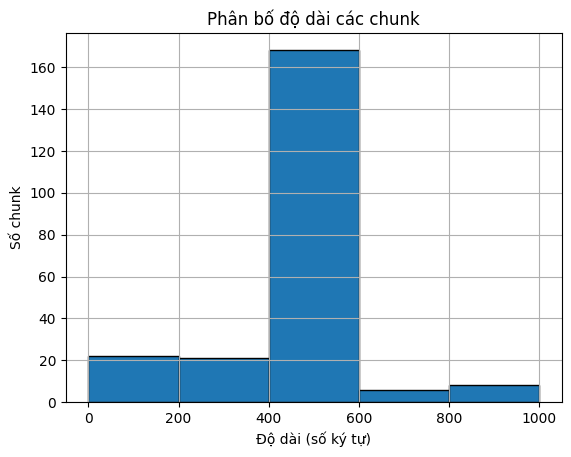

In [66]:
analyze_doc_lengths(final_docs)

In [76]:
embedding_model = HuggingFaceEmbeddings(
    model_name="vinai/phobert-base-v2",
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True}
)

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [77]:
texts = [doc.page_content for doc in final_docs]
metadatas = [doc.metadata for doc in final_docs]

persist_dir = "./bm_db_legal"

vectorstore = Chroma.from_texts(
    texts=texts,
    embedding=embedding_model,
    metadatas=metadatas,
    collection_name="law_docs",
    persist_directory=persist_dir
)
vectorstore.persist()

/tmp/ipython-input-77-781482455.py:13: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectorstore.persist()


In [80]:
law_db = Chroma(
    collection_name="law_docs",
    embedding_function=embedding_model,
    persist_directory=persist_dir
)

In [84]:
retriever = law_db.as_retriever(search_kwargs={"k": 10})
query = "Quy phạm pháp luật là gì?"

results = retriever.invoke(query)

for r in results:
    print("\n--- Kết quả ---")
    print("Nội dung:", r.page_content)
    print("Metadata:", r.metadata)


--- Kết quả ---
Nội dung: Văn bản quy phạm pháp luật là văn bản có chứa quy phạm pháp luật, được ban hành đúng thẩm quyền, hình
thức, trình tự, thủ tục theo quy định của Luật này.
Metadata: {'chuong': 'I', 'ten_dieu': 'văn bản quy phạm pháp luật', 'co_quan_ban_hanh': 'quốc hội', 'loai_van_ban': 'luật', 'noi_ban_hanh': 'hà nội', 'dieu': '2', 'ngay_ban_hanh': '19/02/2025', 'ten_chuong': 'những quy định chung', 'chu_de': 'ban hành văn bản quy phạm pháp luật', 'ma_so': '64/2025/QH15', 'source': 'L_64_2025_QH15.pdf'}

--- Kết quả ---
Nội dung: Luật này quy định về xây dựng, ban hành văn bản quy phạm pháp luật; nội dung cơ bản về tổ chức thi hành
văn bản quy phạm pháp luật.
Luật này không quy định về làm Hiến pháp, sửa đổi Hiến pháp.
Metadata: {'ten_dieu': 'phạm vi điều chỉnh', 'ten_chuong': 'những quy định chung', 'dieu': '1', 'source': 'L_64_2025_QH15.pdf', 'ma_so': '64/2025/QH15', 'noi_ban_hanh': 'hà nội', 'co_quan_ban_hanh': 'quốc hội', 'ngay_ban_hanh': '19/02/2025', 'chuong': 'I', 'loa

In [85]:
!zip -r bm_db_legal.zip bm_db_legal

  adding: bm_db_legal/ (stored 0%)
  adding: bm_db_legal/chroma.sqlite3 (deflated 52%)
  adding: bm_db_legal/bc13b764-fb81-4b4f-800e-ddedb706370b/ (stored 0%)
  adding: bm_db_legal/bc13b764-fb81-4b4f-800e-ddedb706370b/length.bin (deflated 100%)
  adding: bm_db_legal/bc13b764-fb81-4b4f-800e-ddedb706370b/link_lists.bin (stored 0%)
  adding: bm_db_legal/bc13b764-fb81-4b4f-800e-ddedb706370b/header.bin (deflated 61%)
  adding: bm_db_legal/bc13b764-fb81-4b4f-800e-ddedb706370b/data_level0.bin (deflated 100%)
